# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

## 5.13 Table B.4 contains data on the annual US production of blue and gorgonzola cheeses.

In [3]:
# Create the organized data
data = {
    "Year": [
        1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
        1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
        1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
        1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997
    ],
    "Production": [
        7657, 5451, 10883, 9554, 9519, 10047, 10663, 10864, 11447, 12710,
        15169, 16205, 14507, 15400, 16800, 19000, 20198, 18573, 19375, 21032,
        23250, 25219, 28549, 29759, 28262, 28506, 33885, 34776, 35347, 34628,
        33043, 30214, 31013, 31496, 34115, 33433, 34198, 35863, 37789, 34561,
        36434, 34371, 33307, 33295, 36514, 36593, 38311, 42773
    ]
}
# Create the DataFrame
df_production = pd.DataFrame(data).set_index('Year')

# Display the DataFrame
df_production.head()


,Production
Year,
1950,7657
1951,5451
1952,10883
1953,9554
1954,9519


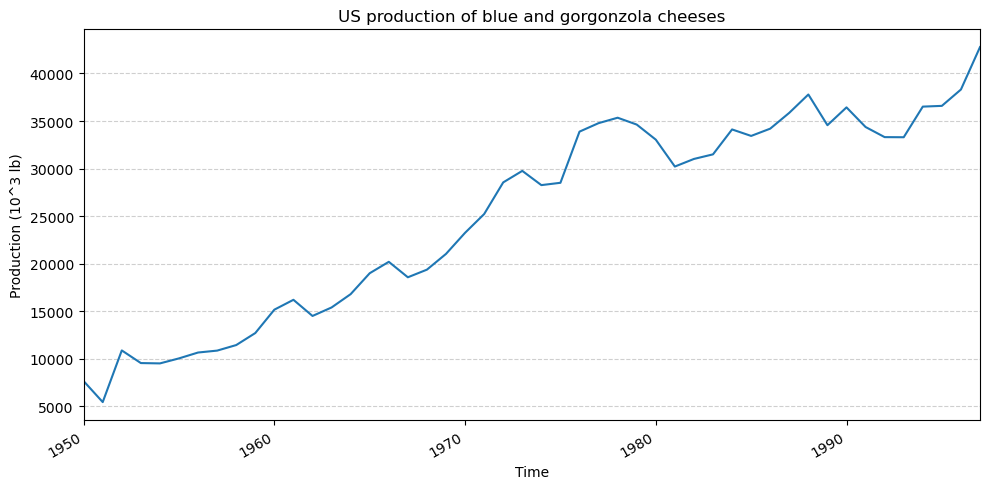

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_production)
ax.set_xlabel('Time')
ax.set_ylabel('Production (10^3 lb)')
ax.set_title('US production of blue and gorgonzola cheeses')
ax.set_xlim(1950,1997)
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

**a. Fit an ARIMA model to this time series, excluding the last
10 observations. Investigate model adequacy. Explain how this
model would be used for forecastin**g.

In [5]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df_production['Production'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.5939
p-value: 0.8724

p-value > alpha; H0: Not Stationary


In [6]:
# Difference the series if non-stationary
diff_series = df_production['Production'].diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -7.0196
p-value: 0.0000

p-value < alpha; Ha: Stationary


    d = 1

In [7]:
prod_series = df_production['Production']

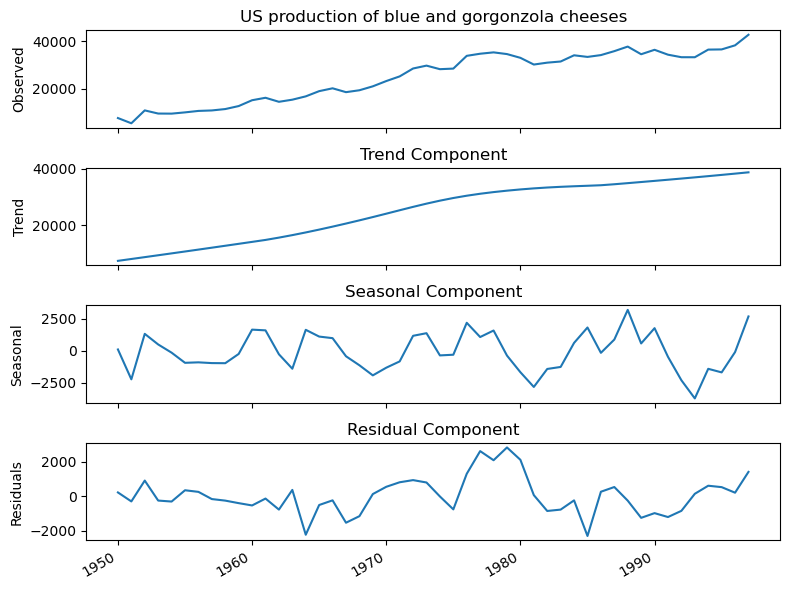

In [8]:
decomposition = STL(prod_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title("US production of blue and gorgonzola cheeses")

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [9]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decomposition.seasonal.dropna())

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -8.102955636464516
      p-value: 1.2851409958809312e-12

p-value < alpha; Ha: Stationary


    D = 0

In [10]:
# Split into train and test
train = df_production[:-10]   # All observations except the last 10
test = df_production[-10:]    # Last 10 observations

# Show the split
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (38, 1)
Test shape: (10, 1)


**PMDArima**

In [11]:
auto_model = pm.auto_arima(train['Production'],          # Fit an automatic ARIMA model to the training data
                           seasonal=True,                # Enable seasonal ARIMA modeling
                           test='adf',                   # Use Augmented Dickey-Fuller test to determine order of differencing (d)
                           stepwise=True,                # Use stepwise search to reduce computation time
                           trace=True)                   # Print progress of model selection to the console

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=669.855, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=657.384, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=658.412, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=659.470, Time=0.01 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.158 seconds


**Manual**

In [12]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(3))]*2        # Define search ranges for seasonal parameters (P, Q): each from 0 to 2

In [13]:
vals = combinator([P_ns, [1], Q_ns, P_s, [0], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},0)')

    m = SARIMAX(train['Production'],           # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(0, 0, 0, 0),   #
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }

Running model #0 using SARIMA(0,1,0)(0,0,0,0)
Running model #15 using SARIMA(0,1,1)(2,0,0,0)
Running model #30 using SARIMA(0,1,3)(1,0,0,0)
Running model #45 using SARIMA(1,1,1)(0,0,0,0)
Running model #60 using SARIMA(1,1,2)(2,0,0,0)
Running model #75 using SARIMA(2,1,0)(1,0,0,0)
Running model #90 using SARIMA(2,1,2)(0,0,0,0)
Running model #105 using SARIMA(2,1,3)(2,0,0,0)
Running model #120 using SARIMA(3,1,1)(1,0,0,0)
Running model #135 using SARIMA(3,1,3)(0,0,0,0)


In [14]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
rank = pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

rank.head()

,index,non-seasonal order,seasonal order,AIC,AICc,model
0,27,"(0, 1, 3)","(0, 0, 0)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,29,"(0, 1, 3)","(0, 0, 2)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,30,"(0, 1, 3)","(1, 0, 0)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,31,"(0, 1, 3)","(1, 0, 1)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,32,"(0, 1, 3)","(1, 0, 2)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [15]:
# Fit SARIMA model with seasonal order
model1 = SARIMAX(train['Production'], 
                order=(0, 1, 3), 
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit1 = model1.fit()

# Display Summary
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   38
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -291.632
Date:                Wed, 09 Apr 2025   AIC                            591.264
Time:                        08:30:33   BIC                            597.250
Sample:                             0   HQIC                           593.278
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4244      0.272      1.559      0.119      -0.109       0.958
ma.L2          0.0340      0.271      0.125      0.900      -0.497       0.565
ma.L3         -0.0851      0.291     -0.293      0.7

In [16]:
# Fit SARIMA model with seasonal order
model1 = SARIMAX(train['Production'], 
                order=(1, 2, 0), 
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit1 = model1.fit()

# Display Summary
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   38
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -316.362
Date:                Wed, 09 Apr 2025   AIC                            636.724
Time:                        08:30:33   BIC                            639.835
Sample:                             0   HQIC                           637.798
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3902      0.107     -3.643      0.000      -0.600      -0.180
sigma2      4.156e+06   9.25e+05      4.494      0.000    2.34e+06    5.97e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-

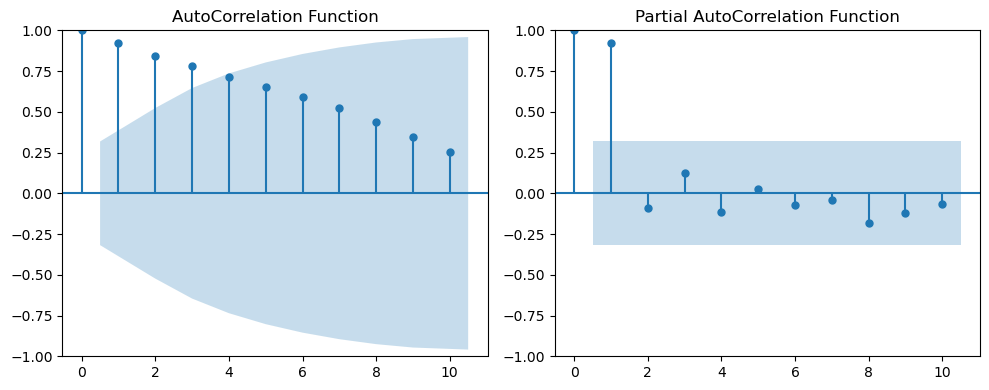

In [17]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(train['Production'], ax=axes[0], lags=10)
axes[0].set_title("AutoCorrelation Function", fontsize=12)

# Simulated Random Walk Data
plot_pacf(train['Production'], ax=axes[1], lags=10)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)

plt.tight_layout()
plt.show()

**ACF (left plot):**
  
    Shows slow decay, which suggests non-stationarity in the level — so d=1 or d=2 might be needed.

    Significant lags up to at least lag 10 — this supports higher MA terms.

**PACF (right plot):**
  
    Has a significant spike at lag 1 and cuts off sharply after that — typical of an AR(1) process.

----------------------

**SARIMA(0,1,3)(0,0,0,0):**
   
    Differencing once (d=1) to handle trend.

    MA(3): This fits the slow ACF decay well.

    No seasonal components: Seems fine if you’ve verified no seasonal behavior.

**SARIMA(1,2,0)(1,0,0,0):**
 
    Differencing twice (d=2), which may be overdifferencing — can distort the series and inflate variance.

    AR(1) and seasonal AR(1): PACF suggests AR(1) is reasonable, but the data does not show strong seasonality, so seasonal AR(1) may be unnecessary.

**Conclusion:** Let's pick the top rank for SARIMA(1,1,X)(0,0,0,0)

In [18]:
rank.head(10)

,index,non-seasonal order,seasonal order,AIC,AICc,model
0,27,"(0, 1, 3)","(0, 0, 0)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,29,"(0, 1, 3)","(0, 0, 2)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,30,"(0, 1, 3)","(1, 0, 0)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,31,"(0, 1, 3)","(1, 0, 1)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,32,"(0, 1, 3)","(1, 0, 2)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,33,"(0, 1, 3)","(2, 0, 0)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,34,"(0, 1, 3)","(2, 0, 1)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,35,"(0, 1, 3)","(2, 0, 2)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,28,"(0, 1, 3)","(0, 0, 1)",590.457946,591.886517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,63,"(1, 1, 3)","(0, 0, 0)",590.581035,592.803258,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [19]:
# Fit SARIMA model with seasonal order
model3 = SARIMAX(train['Production'], 
                order=(1, 1, 3), 
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit3 = model3.fit()

# Display Summary
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   38
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -290.291
Date:                Wed, 09 Apr 2025   AIC                            590.582
Time:                        08:30:33   BIC                            598.064
Sample:                             0   HQIC                           593.099
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9705      0.039     25.203      0.000       0.895       1.046
ma.L1         -0.7328      0.557     -1.316      0.188      -1.824       0.359
ma.L2         -0.2690      0.335     -0.803      0.4

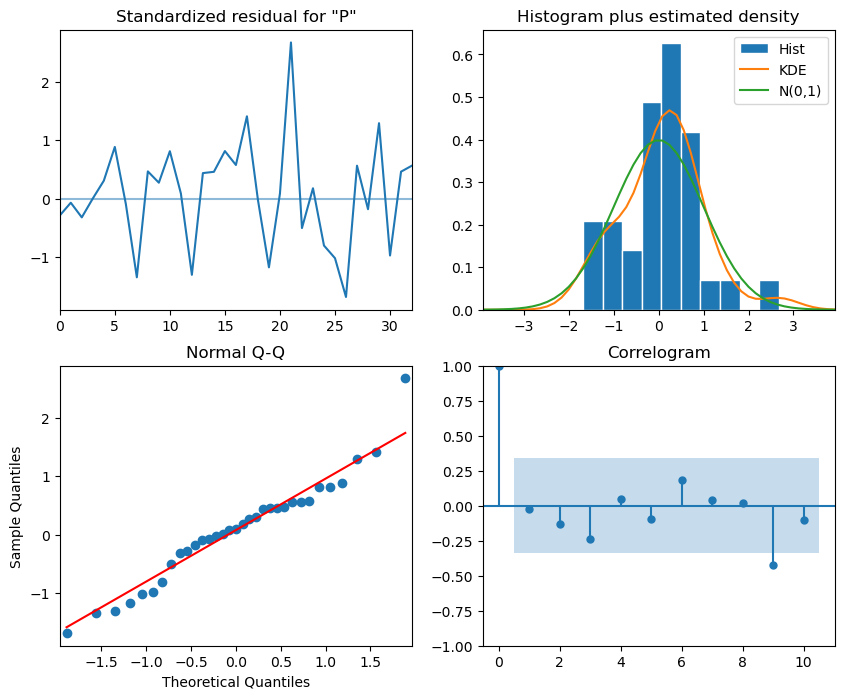

In [20]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit3.plot_diagnostics(figsize=(10, 8))

In [21]:
# Extract the residuals (errors) from the fitted model
residualsm = model_fit3.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residualsm = acorr_ljungbox(residualsm, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residualsm['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residualsm

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,7.800647,0.005223
2,10.849186,0.004407
3,14.114062,0.002754
4,14.182736,0.006734
5,14.338229,0.013598
6,14.514864,0.024385
7,14.570359,0.041919
8,14.618686,0.066998
9,15.325850,0.082366
10,15.452609,0.116411


    Despite SARIMA(1,1,3)(0,0,0,0) shows not be a good model, we will use it as exercise.

**b. Forecast the last 10 observations.**

In [22]:
# Forecast the next 10 time points
forecast = model_fit3.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean

# Ensure the forecast index matches the test data
forecast_mean.index = test.index[:10]  # align forecast index with test index

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Actual': test['Production'],
    'Forecast': forecast_mean,
})

# Calculate forecast error
forecast_df['Error'] = forecast_df['Actual'] - forecast_df['Forecast']

# Display results
forecast_df

,Actual,Forecast,Error
Year,,,
1988,37789,36500.607015,1288.392985
1989,34561,36877.082021,-2316.082021
1990,36434,37269.411720,-835.411720
1991,34371,37650.185803,-3279.185803
1992,33307,38019.744626,-4712.744626
1993,33295,38378.418523,-5083.418523
1994,36514,38726.528096,-2212.528096
1995,36593,39064.384505,-2471.384505
1996,38311,39392.289745,-1081.289745


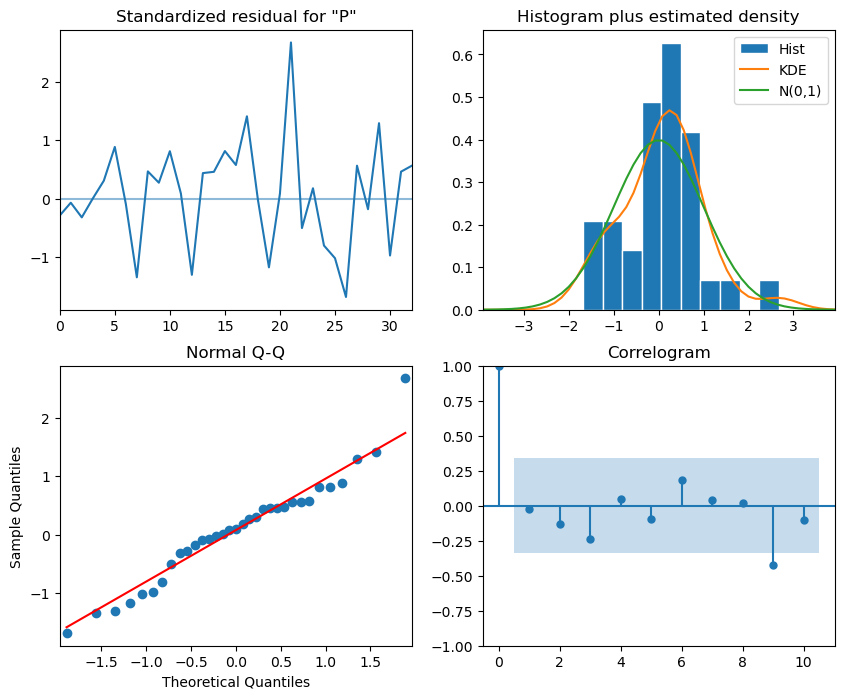

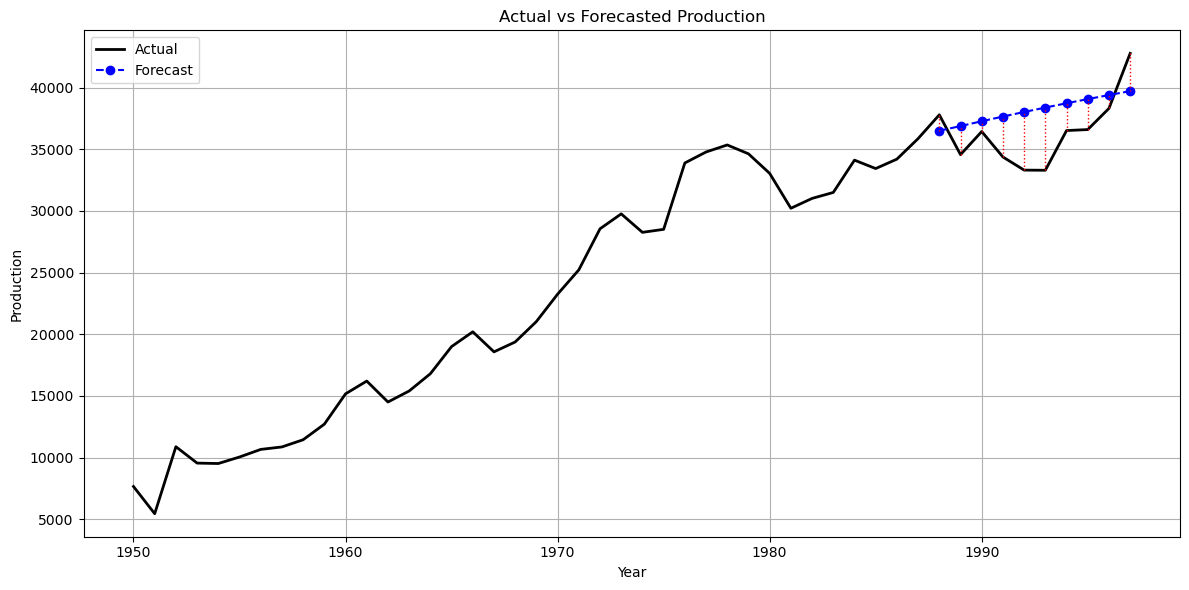

In [23]:
# Combine training and test actuals into one series
full_actual = pd.concat([train['Production'], test['Production']])                # Actual full series
full_forecast = pd.concat([train['Production'], forecast_df['Forecast']])         # Forecast appended to training

# Plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(full_actual.index, full_actual.values, label='Actual', color='black', linewidth=2)

# Plot forecast values (last 10 points)
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue', linestyle='--', marker='o')

# Plot forecast error as vertical red lines
for year in forecast_df.index:
    plt.plot([year, year],
             [forecast_df.loc[year, 'Actual'], forecast_df.loc[year, 'Forecast']],
             color='red', linestyle=':', linewidth=1)

# Titles and labels
plt.title('Actual vs Forecasted Production')
plt.xlabel('Year')
plt.ylabel('Production')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

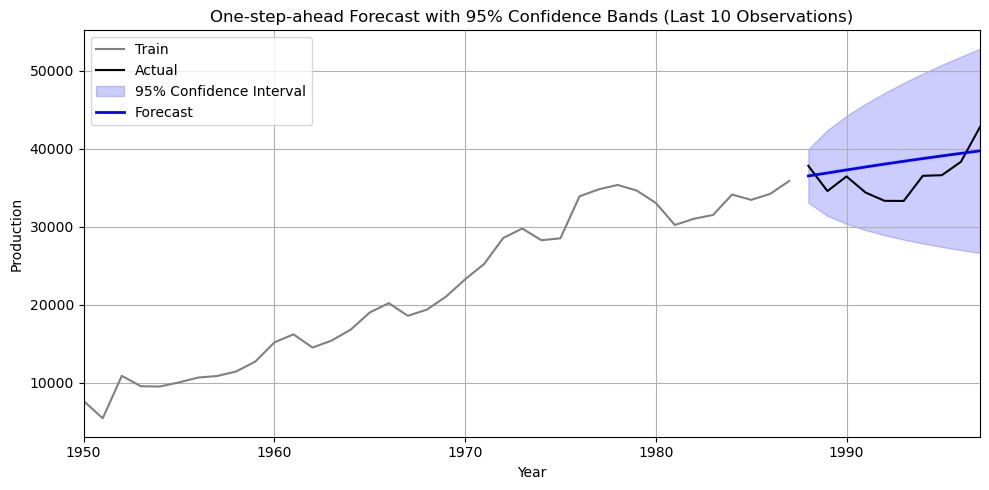

In [24]:
# Generate forecasts
forecast_obj = model_fit3.get_forecast(steps=10)
forecast_mean = forecast_obj.predicted_mean                      # Forecasted values
conf_int = forecast_obj.conf_int()                               # Confidence intervals

# Use actual test period index for forecast and intervals
forecast_mean.index = test.index
conf_int.index = test.index

# Plot actual values, forecasts, and confidence bands
plt.figure(figsize=(10, 5))

# 1. Plot training data
plt.plot(train.index, train['Production'], label='Train', color='gray')

# 2. Plot actual test data
plt.plot(test.index, test['Production'], label='Actual', color='black')

# 3. Plot 95% confidence interval FIRST (so it stays behind)
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],      # Lower bound
                 conf_int.iloc[:, 1],      # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# 4. Plot forecast line LAST to make it visible
plt.plot(test.index,
         forecast_mean,
         label='Forecast',
         color='blue',
         linewidth=2)

# Final styling
plt.title('One-step-ahead Forecast with 95% Confidence Bands (Last 10 Observations)')
plt.xlabel('Year')
plt.ylabel('Production')
plt.xlim([train.index.min(), test.index.max()])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

In [25]:
mae = mean_absolute_error(forecast_df['Actual'], forecast_df['Forecast'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual'], forecast_df['Forecast']))
bias = (forecast_df['Forecast'] - forecast_df['Actual']).mean()

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Bias: {bias:.2f}")

MAE: 2634.29
RMSE: 2967.78
Bias: 1764.12


## 5.15 Table B.5 shows US beverage manufacturer product shipments.
Develop an appropriate ARIMA model and a procedure for forecasting for these data. Explain how prediction intervals would be
computed.

In [26]:
beverage = pd.read_csv('data/US_Beverage_Shipments_Full.csv')

beverage

,Month,Production ($Millions)
0,1992-01-01,3519
1,1992-02-01,3803
2,1992-03-01,4332
3,1992-04-01,4251
4,1992-05-01,4661
...,...,...
175,2006-08-01,7039
176,2006-09-01,6440
177,2006-10-01,6446
178,2006-11-01,6717


In [27]:
beverage['Date'] = pd.to_datetime(beverage['Month'])   # Ensure it's in datetime format
beverage = beverage.set_index('Date')                  # Set as index
beverage = beverage.sort_index()                       # Sort the index chronologically

beverage.drop(columns='Month', inplace=True)           # Drop 'Month' column if still present
beverage = beverage.rename(columns={'Production ($Millions)': 'Production'})

beverage.head()

,Production
Date,
1992-01-01,3519
1992-02-01,3803
1992-03-01,4332
1992-04-01,4251
1992-05-01,4661


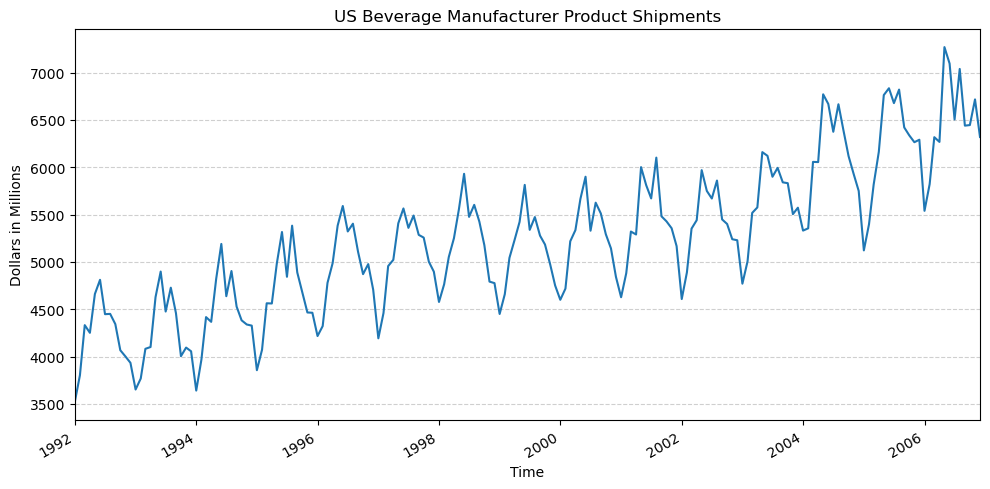

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(beverage)
ax.set_xlabel('Time')
ax.set_ylabel('Dollars in Millions')
ax.set_title('US Beverage Manufacturer Product Shipments')
ax.set_xlim(pd.to_datetime('1992-01-01'), pd.to_datetime('2006-12-01'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [29]:
bev_series = beverage['Production']

In [30]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(bev_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.1291
p-value: 0.9465

p-value > alpha; H0: Not Stationary


In [31]:
# Difference the series if non-stationary
diff_series = bev_series.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.6136
p-value: 0.0055

p-value < alpha; Ha: Stationary


    d = 1

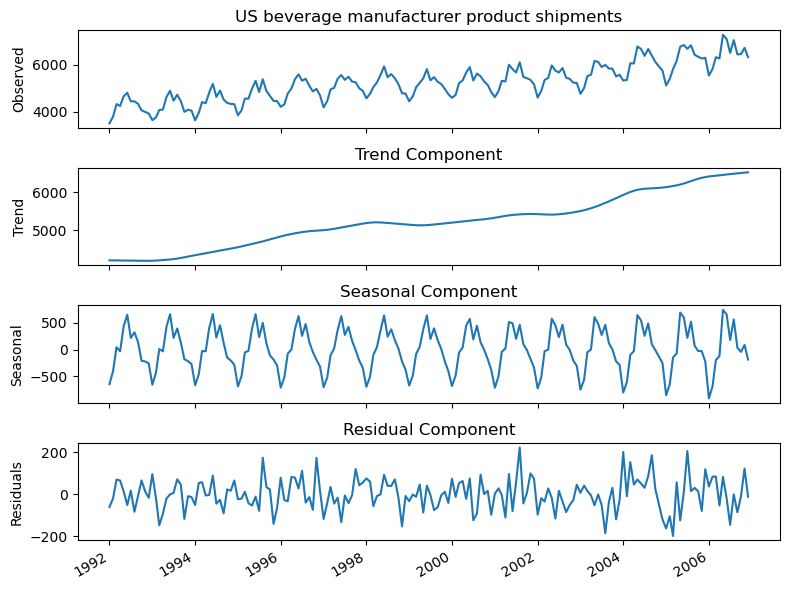

In [32]:
decom_beve = STL(bev_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_beve.observed)
ax1.set_ylabel('Observed')
ax1.set_title("US beverage manufacturer product shipments")

ax2.plot(decom_beve.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_beve.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_beve.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [33]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decom_beve.seasonal)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -7.6135
p-value: 0.0000

p-value < alpha; Ha: Stationary


In [34]:
from pmdarima.arima import nsdiffs


def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

D = determine_seasonal_D(bev_series, 12)
print(f'Seasonal differencing term (D): {D}')

CH Test: D = 0, OCSB Test: D = 1
Seasonal differencing term (D): 0


    D = 0

### Models

In [35]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    bev_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months in a year (seasonal period)
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p from 0 to 3
    start_q=0, max_q=3,         # q from 0 to 3
    start_P=0, max_P=2,         # P from 0 to 2
    start_Q=0, max_Q=2,         # Q from 0 to 2
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2585.412, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2487.363, Time=0.12 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2451.469, Time=0.37 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2387.614, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2363.498, Time=0.23 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2361.817, Time=0.68 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2587.152, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2485.029, Time=0.11 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2444.858, Time=0.44 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2349.367, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2312.572, Time=0.38 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2336.249, Time=0.89 sec
 ARIMA(0,1

In [36]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(3))]*2        # Define search ranges for seasonal parameters (P, Q): each from 0 to 2

In [37]:
d = 1
D = 0
S = 12

In [38]:
vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')

    m = SARIMAX(bev_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }

Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,1)(2,0,0,12)
Running model #30 using SARIMA(0,1,3)(1,0,0,12)
Running model #45 using SARIMA(1,1,1)(0,0,0,12)
Running model #60 using SARIMA(1,1,2)(2,0,0,12)
Running model #75 using SARIMA(2,1,0)(1,0,0,12)
Running model #90 using SARIMA(2,1,2)(0,0,0,12)
Running model #105 using SARIMA(2,1,3)(2,0,0,12)
Running model #120 using SARIMA(3,1,1)(1,0,0,12)
Running model #135 using SARIMA(3,1,3)(0,0,0,12)


In [39]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
rank = pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 
rank.head()

,index,non-seasonal order,seasonal order,AIC,AICc,model
0,35,"(0, 1, 3)","(2, 0, 2)",1930.378289,1931.392373,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,32,"(0, 1, 3)","(1, 0, 2)",1933.380138,1934.163354,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,71,"(1, 1, 3)","(2, 0, 2)",1935.665878,1936.942474,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,68,"(1, 1, 3)","(1, 0, 2)",1936.558391,1937.572476,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,116,"(3, 1, 0)","(2, 0, 2)",1939.663172,1940.670165,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


#### Correlation Analysis

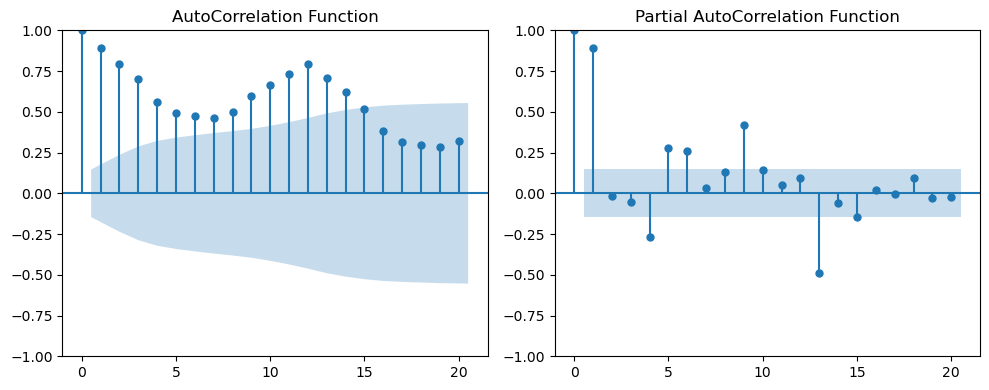

In [40]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(bev_series, ax=axes[0], lags=20)
axes[0].set_title("AutoCorrelation Function", fontsize=12)

# Simulated Random Walk Data
plot_pacf(bev_series, ax=axes[1], lags=20)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)

plt.tight_layout()
plt.show()

**ACF (Left Plot)**

    Slow decay and many spikes above the confidence bounds.

    Suggests non-stationarity, which is expected due to d=1 in both models.

    No clear cutoff → likely MA component needed.

**PACF (Right Plot)**

    Strong spike at lag 1, maybe lag 2.

    Cutoff after that → suggests AR(1) or AR(2).

**ARIMA(0,1,3)(2,0,2)** looks little bit better:

    Because the ACF shows a long tail, consistent with a MA(3). 
    
    PACF doesn't need deep AR terms — strong at lag 1, which MA can absorb.

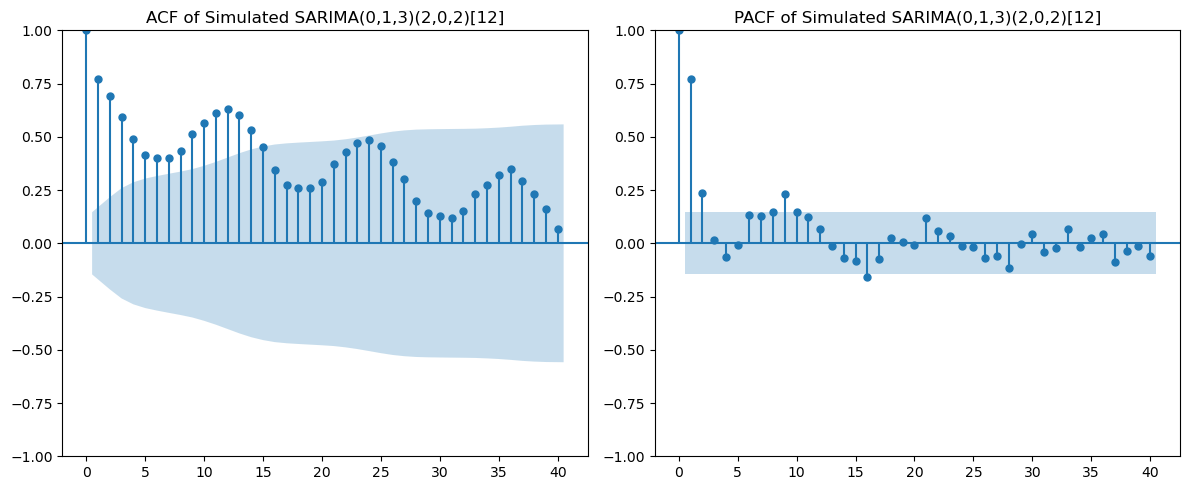

In [41]:
# --- 1. Set up parameters to SARIMA(0,1,3)(2,0,2)[12] ---

# Define the SARIMA model structure
model1 = SARIMAX(endog=bev_series,
                order=(0, 1, 3),                         # ARIMA(0,1,3)
                seasonal_order=(2, 0, 2, 12),            # Seasonal (2,0,2)[12]
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit1 = model1.fit()

# Get the values
fitted_series1 = model_fit1.predict()


# --- 2. Plot ACF and PACF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(fitted_series1, lags=40, ax=axes[0])
axes[0].set_title('ACF of Simulated SARIMA(0,1,3)(2,0,2)[12]')

plot_pacf(fitted_series1, lags=40, ax=axes[1])
axes[1].set_title('PACF of Simulated SARIMA(0,1,3)(2,0,2)[12]')

plt.tight_layout()
plt.show();

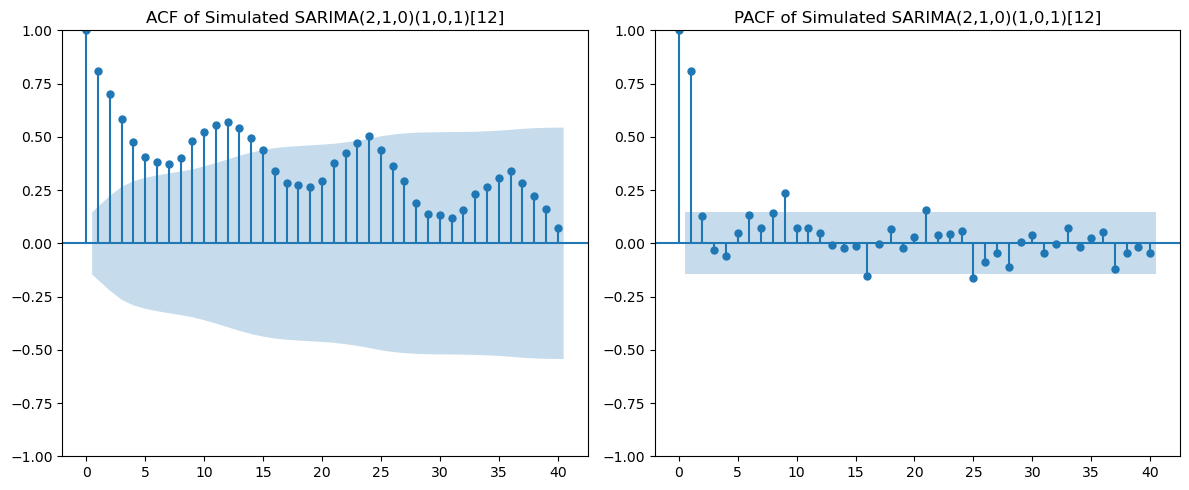

In [42]:
# --- 1. Set up parameters to SARIMA(2,1,0)(1,0,1)[12] ---

# Define the SARIMA model structure
model2 = SARIMAX(endog=bev_series,
                order=(2, 1, 0),                         
                seasonal_order=(1, 0, 1, 12),            
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit2 = model2.fit()

# Get the values
fitted_series2 = model_fit2.predict()


# --- 2. Plot ACF and PACF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(fitted_series2, lags=40, ax=axes[0])
axes[0].set_title('ACF of Simulated SARIMA(2,1,0)(1,0,1)[12]')

plot_pacf(fitted_series2, lags=40, ax=axes[1])
axes[1].set_title('PACF of Simulated SARIMA(2,1,0)(1,0,1)[12]')

plt.tight_layout()
plt.show();

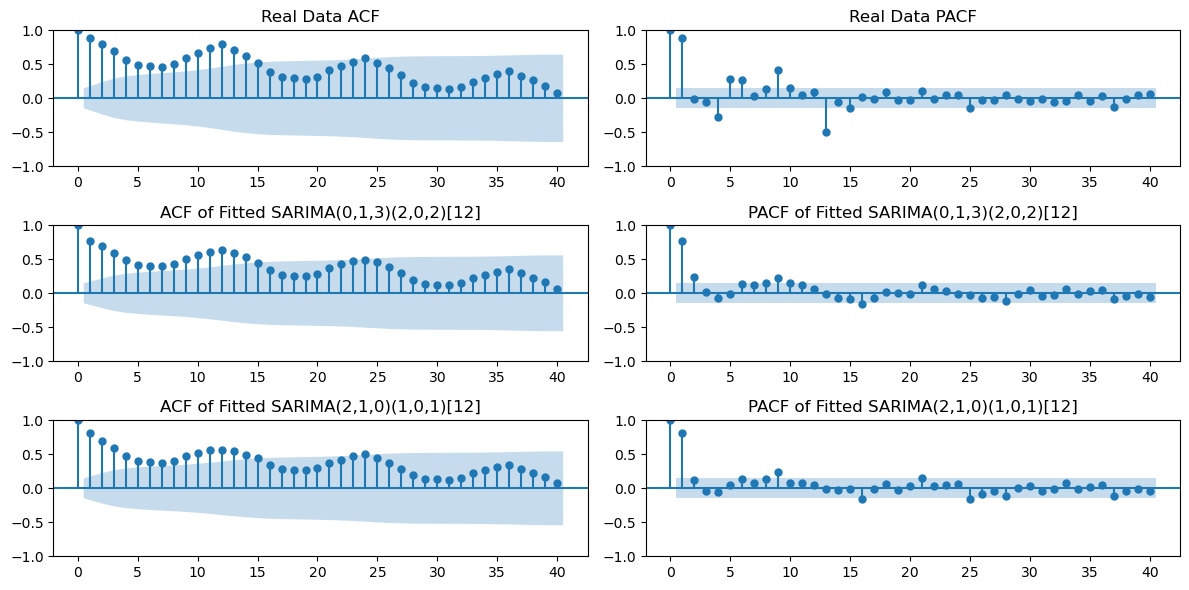

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

plot_acf(bev_series, lags=40, ax=axes[0,0])
axes[0,0].set_title('Real Data ACF')

plot_pacf(bev_series, lags=40, ax=axes[0,1])
axes[0,1].set_title('Real Data PACF')

plot_acf(fitted_series1, lags=40, ax=axes[1,0])
axes[1,0].set_title('ACF of Fitted SARIMA(0,1,3)(2,0,2)[12]')

plot_pacf(fitted_series1, lags=40, ax=axes[1,1])
axes[1,1].set_title('PACF of Fitted SARIMA(0,1,3)(2,0,2)[12]')

plot_acf(fitted_series2, lags=40, ax=axes[2,0])
axes[2,0].set_title('ACF of Fitted SARIMA(2,1,0)(1,0,1)[12]')

plot_pacf(fitted_series2, lags=40, ax=axes[2,1])
axes[2,1].set_title('PACF of Fitted SARIMA(2,1,0)(1,0,1)[12]')


plt.tight_layout()
plt.show()

In [44]:
fitted_series1 = model_fit1.predict()
fitted_series2 = model_fit2.predict()

beverage['(0,1,3,2,0,2)'] = fitted_series1
beverage['(2,1,0,1,0,1)'] = fitted_series2

beverage = beverage.iloc[1:]   # Drop the first row

beverage.head()

,Production,"(0,1,3,2,0,2)","(2,1,0,1,0,1)"
Date,,,
1992-02-01,3803,3519.000000,2391.299962
1992-03-01,4332,3799.719511,3101.281292
1992-04-01,4251,4325.904473,3886.739084
1992-05-01,4661,4251.639163,4105.072593
1992-06-01,4811,4657.832782,4428.515883


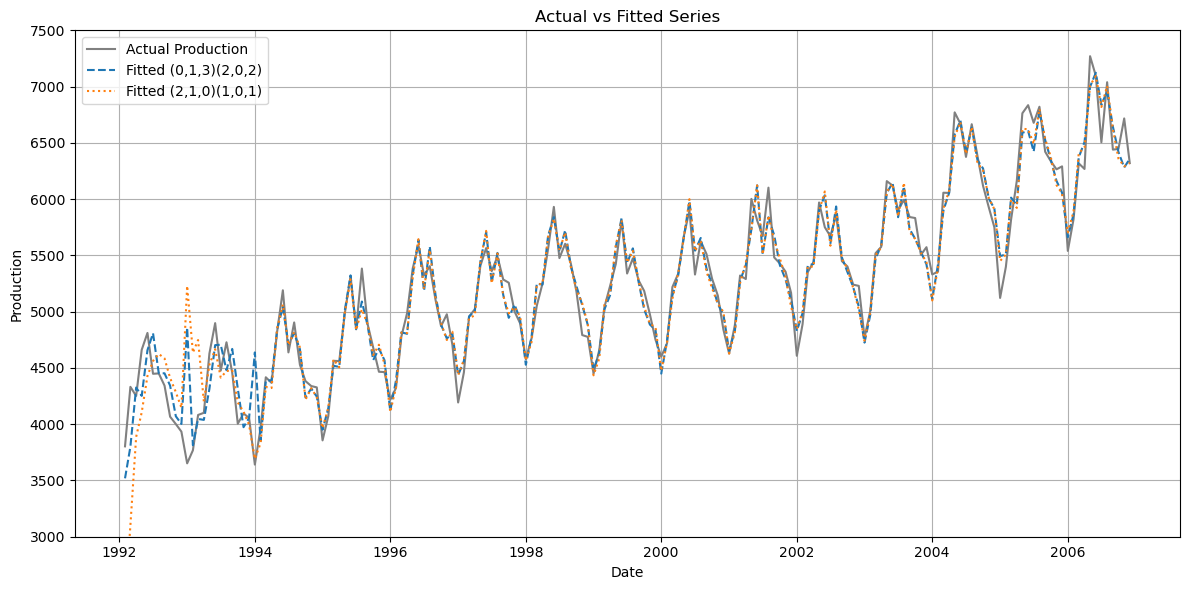

In [45]:
# Plot actual and both fitted series
plt.figure(figsize=(12, 6))                                      

plt.plot(beverage.index, beverage['Production'], label='Actual Production', color='gray')          # Actual
plt.plot(beverage.index, beverage['(0,1,3,2,0,2)'], label='Fitted (0,1,3)(2,0,2)', linestyle='--')  # Fitted 1
plt.plot(beverage.index, beverage['(2,1,0,1,0,1)'], label='Fitted (2,1,0)(1,0,1)', linestyle=':')   # Fitted 2

plt.title('Actual vs Fitted Series')                      
plt.xlabel('Date')                                        
plt.ylabel('Production')  
plt.ylim(3000,7500)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()                                               

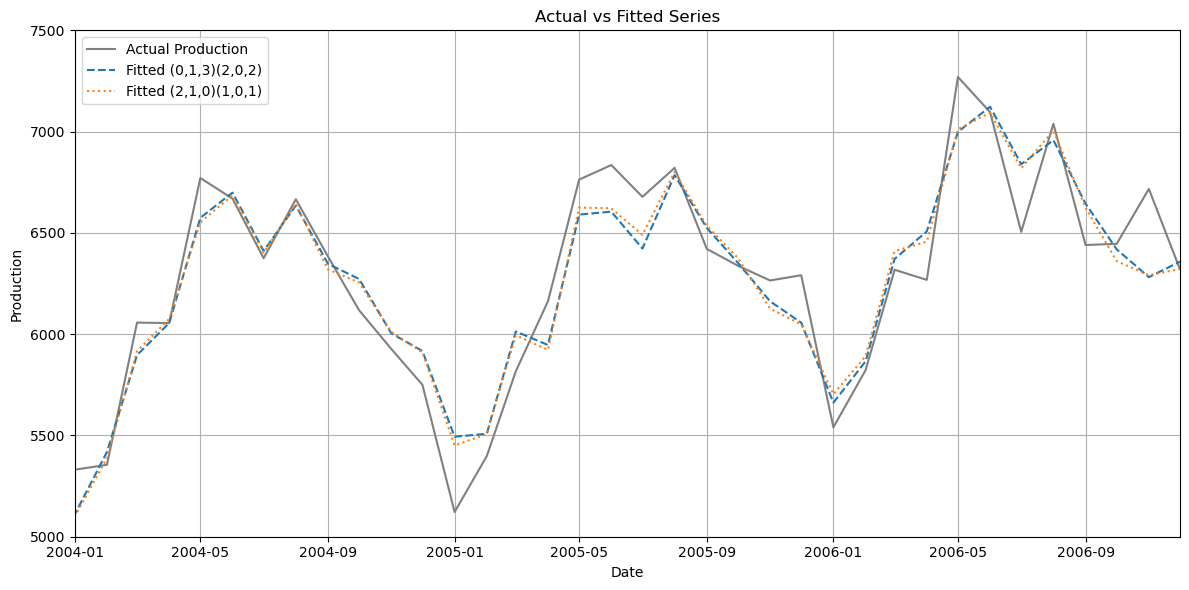

In [46]:
# Plot actual and both fitted series
plt.figure(figsize=(12, 6))                                      # Set figure size

plt.plot(beverage.index, beverage['Production'], label='Actual Production', color='gray')          # Actual
plt.plot(beverage.index, beverage['(0,1,3,2,0,2)'], label='Fitted (0,1,3)(2,0,2)', linestyle='--')  # Fitted 1
plt.plot(beverage.index, beverage['(2,1,0,1,0,1)'], label='Fitted (2,1,0)(1,0,1)', linestyle=':')   # Fitted 2

plt.title('Actual vs Fitted Series')                      
plt.xlabel('Date')                                        
plt.ylabel('Production')  
plt.ylim(5000,7500)
plt.xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-01'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()       

In [47]:
# Calculate MAE for both models
mae_model1 = mean_absolute_error(beverage['Production'], beverage['(0,1,3,2,0,2)'])
mae_model2 = mean_absolute_error(beverage['Production'], beverage['(2,1,0,1,0,1)'])

# Calculate RMSE for both models
rmse_model1 = np.sqrt(mean_squared_error(beverage['Production'], beverage['(0,1,3,2,0,2)']))
rmse_model2 = np.sqrt(mean_squared_error(beverage['Production'], beverage['(2,1,0,1,0,1)']))

# Print the results
print(f"MAE (0,1,3)(2,0,2): {mae_model1:.2f}")
print(f"MAE (2,1,0)(1,0,1): {mae_model2:.2f}")
print()
print(f"RMSE (0,1,3)(2,0,2): {rmse_model1:.2f}")
print(f"RMSE (2,1,0)(1,0,1): {rmse_model2:.2f}")

MAE (0,1,3)(2,0,2): 125.01
MAE (2,1,0)(1,0,1): 142.47

RMSE (0,1,3)(2,0,2): 190.08
RMSE (2,1,0)(1,0,1): 249.34


In [48]:
# Calculate MAPE for ARIMA(0,1,3)(2,0,2)
mape1 = (np.abs(beverage['Production'] - beverage['(0,1,3,2,0,2)']) / beverage['Production']).mean() * 100

# Calculate MAPE for ARIMA(2,1,0)(1,0,1)
mape2 = (np.abs(beverage['Production'] - beverage['(2,1,0,1,0,1)']) / beverage['Production']).mean() * 100

# Print the results
print(f"MAPE (0,1,3)(2,0,2): {mape1:.2f}%")
print(f"MAPE (2,1,0)(1,0,1): {mape2:.2f}%")

MAPE (0,1,3)(2,0,2): 2.52%
MAPE (2,1,0)(1,0,1): 2.96%


    We can conclude that the model ARIMA(0,1,3)(2,0,2) performs slightly better than ARIMA(2,1,0)(1,0,1) in terms of predictive accuracy — it has lower errors across MAE, RMSE, and MAPE.

In [49]:
# Forecast the next 5 time points
forecast_5 = model_fit1.get_forecast(steps=5)

# Extract predicted mean
forecast_mean_5 = forecast_5.predicted_mean

# Extract confidence intervals
conf_int_5 = forecast_5.conf_int()

# Display the forecast
forecast_result = pd.DataFrame({
    'Forecast': forecast_mean_5,
    'Lower 95% CI': conf_int_5.iloc[:, 0],
    'Upper 95% CI': conf_int_5.iloc[:, 1]
})

forecast_result

,Forecast,Lower 95% CI,Upper 95% CI
2007-01-01,5807.751610,5544.196569,6071.306651
2007-02-01,6094.285958,5815.091627,6373.480289
2007-03-01,6617.118303,6323.786590,6910.450016
2007-04-01,6662.670565,6342.476378,6982.864752
2007-05-01,7416.292063,7071.320785,7761.263342


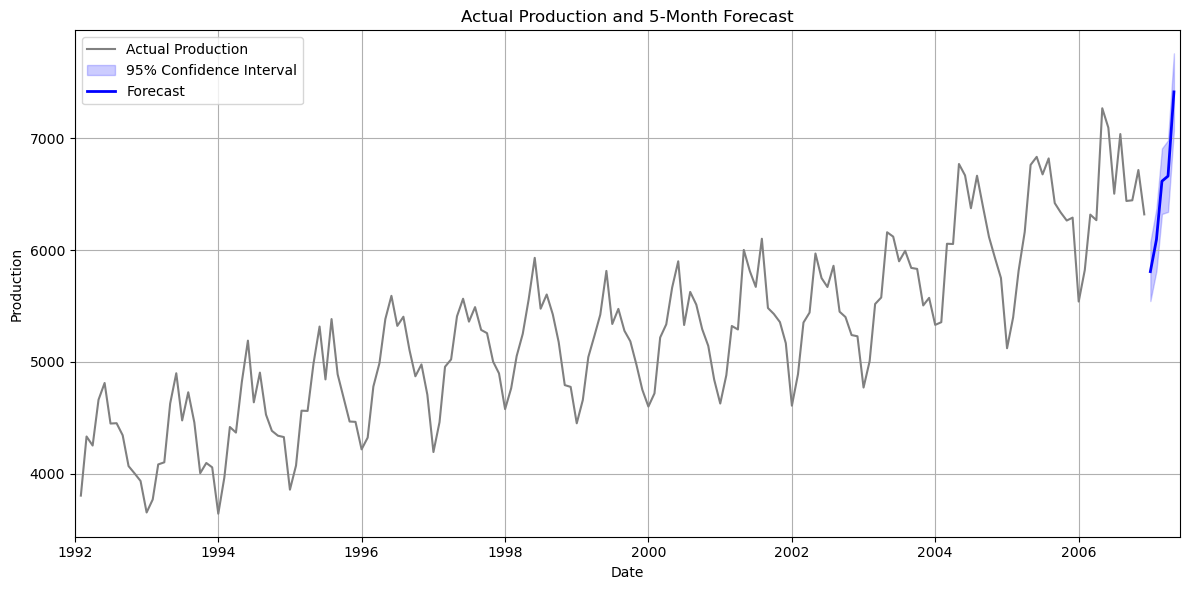

In [50]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(beverage.index, beverage['Production'], label='Actual Production', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_mean_5.index,
                 conf_int_5.iloc[:, 0],     # Lower bound
                 conf_int_5.iloc[:, 1],     # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_result['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Actual Production and 5-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.xlim(pd.to_datetime('1992-01-01'), pd.to_datetime('2007-06-01'))
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show();

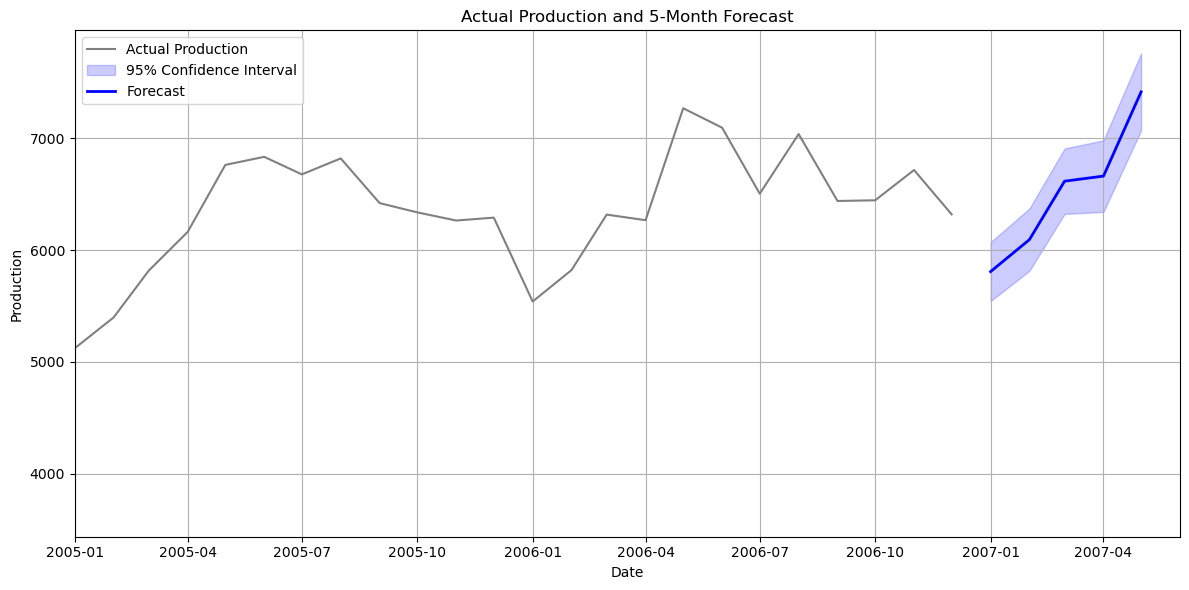

In [51]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(beverage.index, beverage['Production'], label='Actual Production', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_mean_5.index,
                 conf_int_5.iloc[:, 0],     # Lower bound
                 conf_int_5.iloc[:, 1],     # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_result['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Actual Production and 5-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2007-06-01'))
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show();

## 5.16 Table B.6 contains data on the global mean surface air temperature anomaly. 
Develop an appropriate ARIMA model and a procedure for
forecasting for these data. Explain how prediction intervals would
be computed.

In [52]:
temp = pd.read_csv('data/Temperature_and_CO2.csv')
temp.head()

,Year,Anomaly (°C),CO2 (ppmv)
0,1880,-0.11,290.7
1,1881,-0.13,291.2
2,1882,-0.01,291.7
3,1883,-0.04,292.1
4,1884,-0.42,292.6


In [53]:
temp['Date'] = pd.to_datetime(temp['Year'].astype(int), format='%Y')  # Convert year to datetime properly
temp = temp.set_index('Date')                                         # Set datetime as index
temp = temp.sort_index()                                              # Sort by date
temp.drop(columns='Year', inplace=True)                               # Drop original Year column
temp = temp.rename(columns={'Anomaly (°C)': 'Temp',                   # Rename columns
                            'CO2 (ppmv)': 'CO2'})
temp

,Temp,CO2
Date,,
1880-01-01,-0.11,290.7
1881-01-01,-0.13,291.2
1882-01-01,-0.01,291.7
1883-01-01,-0.04,292.1
1884-01-01,-0.42,292.6
...,...,...
2000-01-01,0.41,369.5
2001-01-01,0.56,371.0
2002-01-01,0.70,373.1


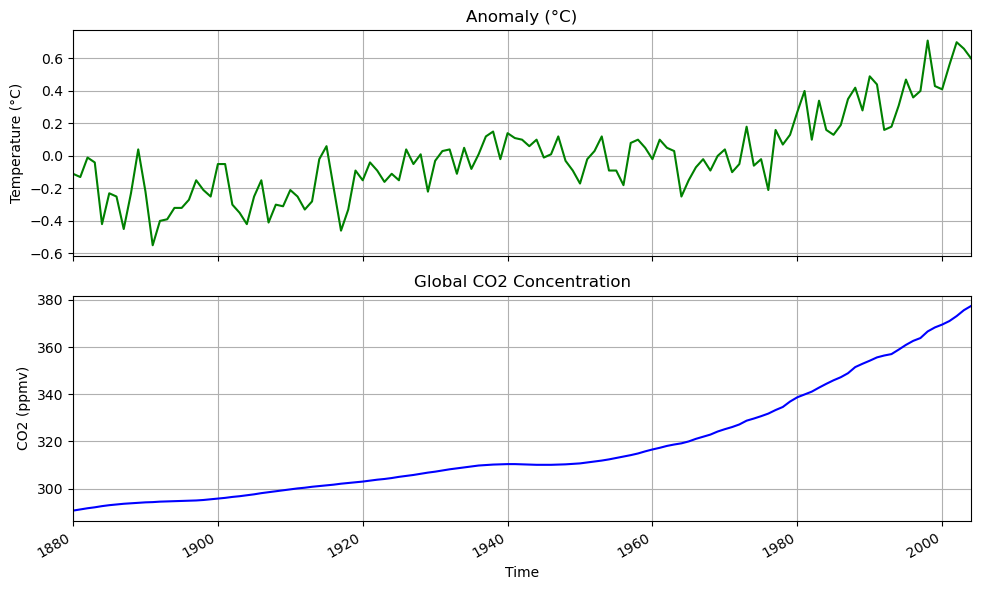

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

ax1.plot(temp['Temp'], color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Anomaly (°C)')
ax1.set_xlim(pd.to_datetime('1880-01-01'), pd.to_datetime('2004-01-01'))
ax1.grid(True) 

ax2.plot(temp['CO2'], color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('CO2 (ppmv)')
ax2.set_title('Global CO2 Concentration')
ax2.set_xlim(pd.to_datetime('1880-01-01'), pd.to_datetime('2004-01-01'))
ax2.grid(True) 

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [55]:
temp_series = temp['Temp']

In [56]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(temp_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 1.2687
p-value: 0.9964

p-value > alpha; H0: Not Stationary


In [57]:
# Difference the series if non-stationary
diff_series = temp_series.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -8.1269
p-value: 0.0000

p-value < alpha; Ha: Stationary


    d = 1

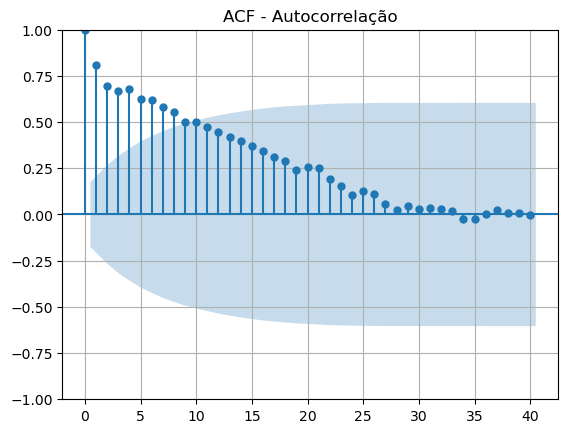

In [58]:
plot_acf(temp_series, lags=40)
plt.title("ACF - Autocorrelação")
plt.grid(True)
plt.show()

**Test Seasonality**

In [59]:
# Define the seasonal periods to test (2 to 10)
seasonal_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop over seasonal periods and run the Canova-Hansen test
for S in seasonal_periods:
    print(f"Testing with seasonal period = {S}")
    
    ch_test = CHTest(m=S)   # Initialize the CHTest with the seasonal period

    D = ch_test.estimate_seasonal_differencing_term(temp_series) # Estimate seasonal differencing term
    
    print(f"Suggested seasonal differencing term (D): {D}\n")


Testing with seasonal period = 2
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 3
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 4
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 5
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 6
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 7
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 8
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 9
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 10
Suggested seasonal differencing term (D): 0



     D = 0

In [60]:
from pmdarima.arima import nsdiffs


def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

D = determine_seasonal_D(temp_series, 12)
print(f'Seasonal differencing term (D): {D}')

Seasonal differencing term (D): 0


In [61]:
# Perform a full grid search for ARIMA model only (non-seasonal)
auto_model_arima = pm.auto_arima(
    temp_series,                # Your time series data
    seasonal=False,             # Disable seasonal component (ARIMA only)
    d=1,                        # Set non-seasonal differencing
    start_p=0, max_p=3,         # p range: 0 to 3
    start_q=0, max_q=3,         # q range: 0 to 3
    stepwise=False,             # Full grid search
    trace=True,                 # Print model search process
    error_action='ignore',      # Skip models that fail
    suppress_warnings=True,     # Hide convergence warnings
    information_criterion='aic' # Use AIC to rank models
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.659, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-142.326, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-148.379, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-134.466, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-121.692, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-146.108, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-146.415, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-145.641, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-135.201, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-148.708, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-147.027, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-147.895, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-145.913, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-147.172, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-149.151, Time=0.16 sec

Best mode

In [62]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


pv, qv = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
dv = [1]                         # Define search ranges for seasonal parameters (P, Q): each from 0 to 2

In [63]:
vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations

    print(f'Running model #{i} using ARIMA({p},{d},{q})')
    
    m = ARIMA(temp_series, order=(p,d,q))   # Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'model': res                        # Fitted model object
    }

Running model #0 using ARIMA(0,1,0)
Running model #1 using ARIMA(0,1,1)
Running model #2 using ARIMA(0,1,2)
Running model #3 using ARIMA(0,1,3)
Running model #4 using ARIMA(1,1,0)
Running model #5 using ARIMA(1,1,1)
Running model #6 using ARIMA(1,1,2)
Running model #7 using ARIMA(1,1,3)
Running model #8 using ARIMA(2,1,0)
Running model #9 using ARIMA(2,1,1)
Running model #10 using ARIMA(2,1,2)
Running model #11 using ARIMA(2,1,3)
Running model #12 using ARIMA(3,1,0)
Running model #13 using ARIMA(3,1,1)
Running model #14 using ARIMA(3,1,2)
Running model #15 using ARIMA(3,1,3)


In [64]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()  

,index,order,AIC,AICc,model
0,14,"(3, 1, 2)",-148.529623,-147.811674,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,9,"(2, 1, 1)",-147.744925,-147.40879,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,7,"(1, 1, 3)",-147.235707,-146.727233,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,15,"(3, 1, 3)",-147.178519,-146.213002,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,11,"(2, 1, 3)",-147.055826,-146.337877,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [65]:
# Define the ARIMA model structure
modelM = ARIMA(endog=temp_series,
                order=(3, 1, 2))

# Fit the model
model_fitM = modelM.fit()

# Display Summary
print(model_fitM.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                  125
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  80.265
Date:                Wed, 09 Apr 2025   AIC                           -148.530
Time:                        08:33:27   BIC                           -131.608
Sample:                    01-01-1880   HQIC                          -141.656
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6880      0.181     -3.807      0.000      -1.042      -0.334
ar.L2         -0.1455      0.199     -0.729      0.466      -0.536       0.245
ar.L3         -0.3255      0.096     -3.388      0.0

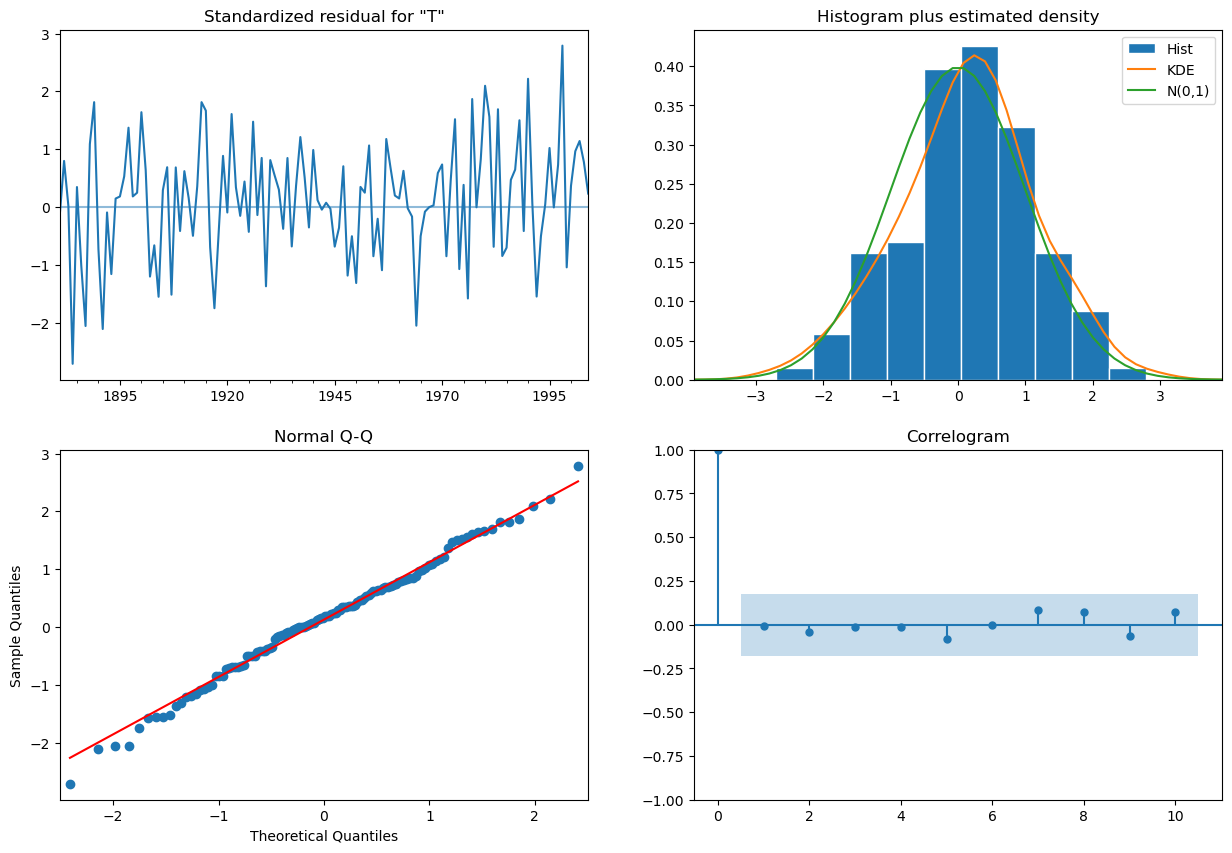

In [66]:
# Plots diagnostic checks for the fitted ARIMA model
model_fitM.plot_diagnostics(figsize=(15,10))
plt.show()

In [67]:
# Extract the residuals (errors) from the fitted model
residuals = model_fitM.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.003643,0.951869
2,0.329512,0.848101
3,0.344317,0.951489
4,0.350547,0.986322
5,1.286538,0.936311
6,1.294689,0.971950
7,2.751732,0.906980
8,3.293936,0.914581
9,4.161531,0.900463
10,5.076991,0.885976


In [68]:
fitted_seriesM = model_fitM.predict()
fitted_seriesM

1880-01-01    0.000000
1881-01-01   -0.110000
1882-01-01   -0.125045
1883-01-01   -0.042904
1884-01-01   -0.072492
                ...   
2000-01-01    0.363400
2001-01-01    0.438071
2002-01-01    0.555815
2003-01-01    0.561733
2004-01-01    0.570457
Freq: YS-JAN, Name: predicted_mean, Length: 125, dtype: float64

In [69]:
# Get the values
fitted_seriesM = model_fitM.predict()

temp = temp.drop(columns='CO2')

temp['(3,1,2,0,0,0)'] = fitted_seriesM

temp = temp.iloc[1:]   # Drop the first row

temp['Error'] = temp['Temp'] - temp['(3,1,2,0,0,0)']

temp.head()

,Temp,"(3,1,2,0,0,0)",Error
Date,,,
1881-01-01,-0.13,-0.110000,-0.020000
1882-01-01,-0.01,-0.125045,0.115045
1883-01-01,-0.04,-0.042904,0.002904
1884-01-01,-0.42,-0.072492,-0.347508
1885-01-01,-0.23,-0.274446,0.044446


In [70]:
temp.tail()

,Temp,"(3,1,2,0,0,0)",Error
Date,,,
2000-01-01,0.41,0.363400,0.046600
2001-01-01,0.56,0.438071,0.121929
2002-01-01,0.70,0.555815,0.144185
2003-01-01,0.66,0.561733,0.098267
2004-01-01,0.60,0.570457,0.029543


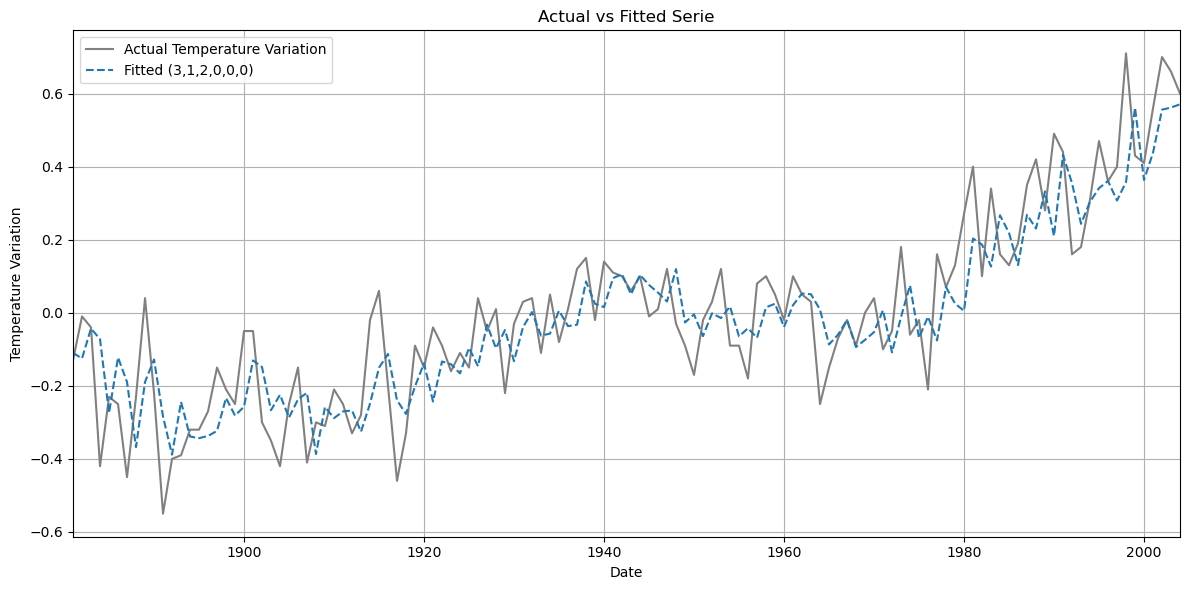

In [71]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(temp.index, temp['Temp'], label='Actual Temperature Variation', color='gray')     # Actual
plt.plot(temp.index, temp['(3,1,2,0,0,0)'], label='Fitted (3,1,2,0,0,0)', linestyle='--')  # Fitted

plt.title('Actual vs Fitted Serie')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature Variation')  
plt.xlim(pd.to_datetime('1881-01-01'), pd.to_datetime('2004-01-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()      

MAPE is not good for values close to zero.

In [72]:
rmse = mean_squared_error(temp['Temp'], temp['(3,1,2,0,0,0)'])
mae = mean_absolute_error(temp['Temp'], temp['(3,1,2,0,0,0)'])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.02
MAE: 0.10


In [73]:
# Forecast the next 5 time points
forecast_5m = model_fitM.get_forecast(steps=5)

# Extract predicted mean
forecast_mean_5m = forecast_5m.predicted_mean

# Extract confidence intervals
conf_int_5m = forecast_5m.conf_int()

# Display the forecast
forecast_resultm = pd.DataFrame({
    'Forecast': forecast_mean_5m,
    'Lower 95% CI': conf_int_5m.iloc[:, 0],
    'Upper 95% CI': conf_int_5m.iloc[:, 1]
})

forecast_resultm

,Forecast,Lower 95% CI,Upper 95% CI
2005-01-01,0.560426,0.313024,0.807828
2006-01-01,0.595031,0.314021,0.876040
2007-01-01,0.596512,0.310084,0.882939
2008-01-01,0.603338,0.313388,0.893289
2009-01-01,0.587163,0.280231,0.894096


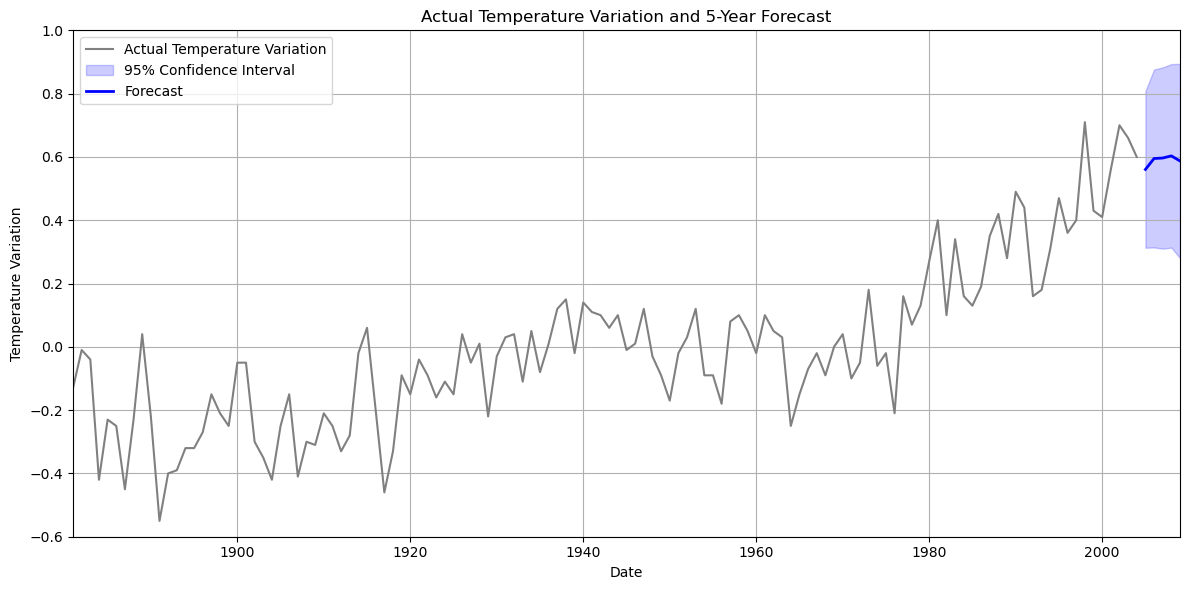

In [74]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(temp.index, temp['Temp'], label='Actual Temperature Variation', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_mean_5m.index,
                 conf_int_5m.iloc[:, 0],     # Lower bound
                 conf_int_5m.iloc[:, 1],     # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_resultm['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Actual Temperature Variation and 5-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature Variation')
plt.xlim(pd.to_datetime('1881-01-01'), pd.to_datetime('2009-01-01'))
plt.ylim(-0.6, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show();